Atmospheric CO2 levels are an important consideration in the ongoing analysis of global climate change. This brief excerpt from a comprehensive climatological analysis I recently completed will analyze whether CO2 levels can be reliably forecast.

We begin by loading the necessary packages and data.

In [42]:
library(fpp2)
library(nortest)
library(tseries)
library(fitdistrplus)
co2_global_df = read.csv('../Data/CO2 Global Arranged.csv',header=TRUE,stringsAsFactors = FALSE)
co2_global = as.numeric(co2_global_df$average)
co2_global_ts = ts(co2_global,frequency=12,start = c(1980,1))

We proceed with a basic visualization of the data.

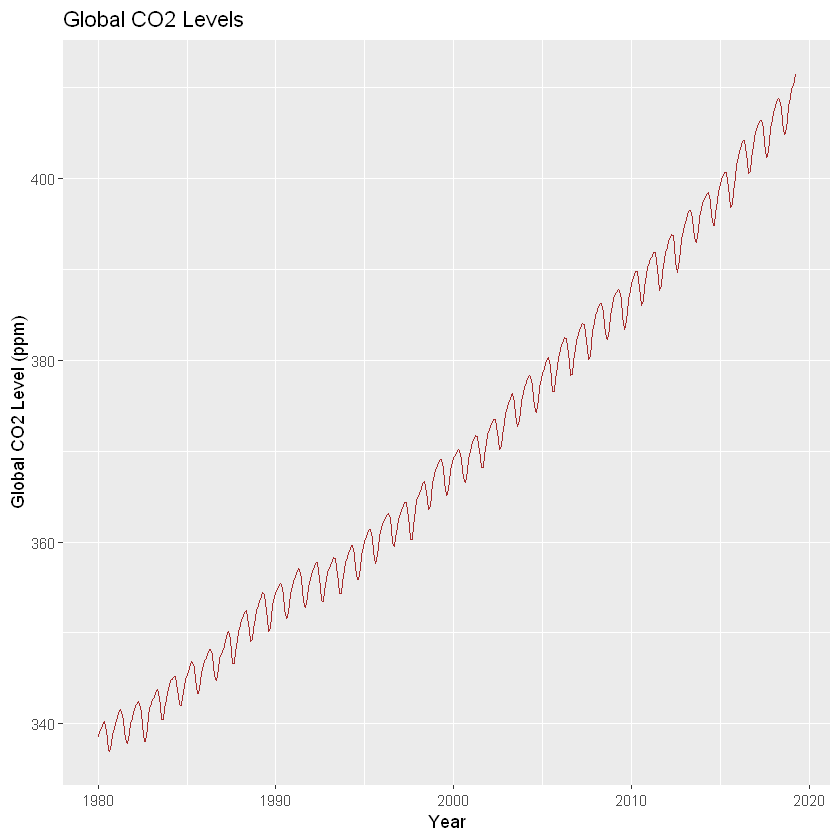

In [19]:
autoplot(co2_global_ts,col="brown")+xlab("Year")+ylab("Global CO2 Level (ppm)")+
  ggtitle("Global CO2 Levels")

In [ ]:
We see a clear upward trend, as expected but we also observe strong seasonality, which we explore next.


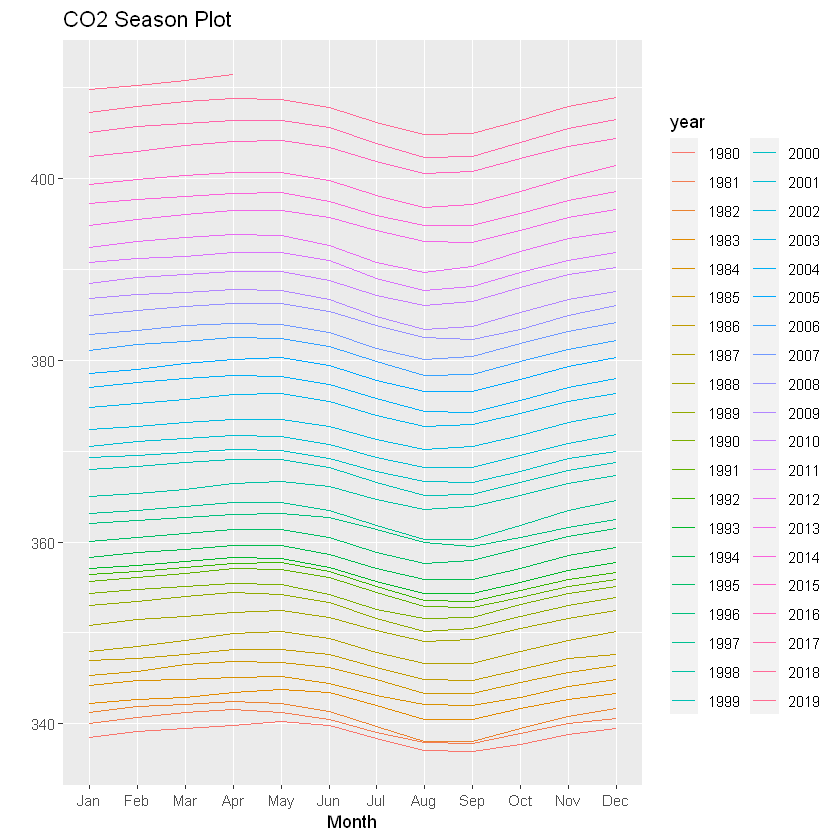

In [20]:
ggseasonplot(co2_global_ts)+ggtitle('CO2 Season Plot')

There is an obvious drop during the months of July, August and September - the northern hemisphere summer. That is when the majority of Earth's vegetation (which resides in the northern hemisphere as the northern hemisphere has significantly more land) is in bloom, and is absorbing CO2.

Next, we will decompose the CO2 data into seasonal, trend and remainder components using STL.


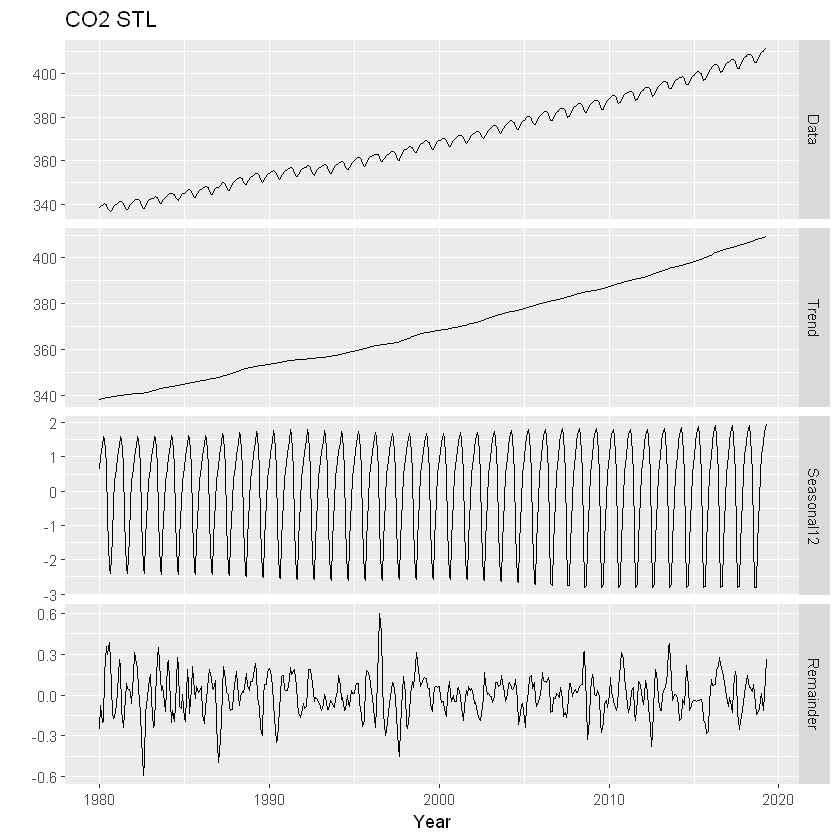

In [21]:
co2_stl = mstl(co2_global_ts)
autoplot(co2_stl)+xlab("Year")+ggtitle("CO2 STL")

The trend is almost linear, and is significantly more powerful than the seasonal component, as can be seen by the scales 
of the respective panels above.

The first question to be asked in any time series analysis is whether the time series is stationary.
We can see pretty clearly from the trend that our series is not, but we apply two formal tests to confirm this.
The Augmented Dickey-Fuller test has a null hypothesis of non-stationarity, 
while the Kolmogorov-Smirnov (KPSS) test's null hypothesis of stationarity.

In [27]:
print(adf.test(co2_global_ts))
print(kpss.test(co2_global_ts))


	Augmented Dickey-Fuller Test

data:  co2_global_ts
Dickey-Fuller = -0.63388, Lag order = 7, p-value = 0.9757
alternative hypothesis: stationary



Warning message in kpss.test(co2_global_ts):
"p-value smaller than printed p-value"


	KPSS Test for Level Stationarity

data:  co2_global_ts
KPSS Level = 7.8742, Truncation lag parameter = 5, p-value = 0.01



Recalling the differing null hypotheses of the tests, we observe that both tests indicate non-stationarity, as we expected.

To obtain stationarity, we first apply first-order differencing to the series.

In [28]:
diffs = diff(co2_global_ts)
adf.test(diffs)
kpss.test(diffs)

Warning message in adf.test(diffs):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  diffs
Dickey-Fuller = -33.15, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


Warning message in kpss.test(diffs):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  diffs
KPSS Level = 0.052789, Truncation lag parameter = 5, p-value = 0.1


Both tests indicate that the time series is now stationary, after first-order differencing.

Next, we introduce the ACF to assess possible ARIMA models.

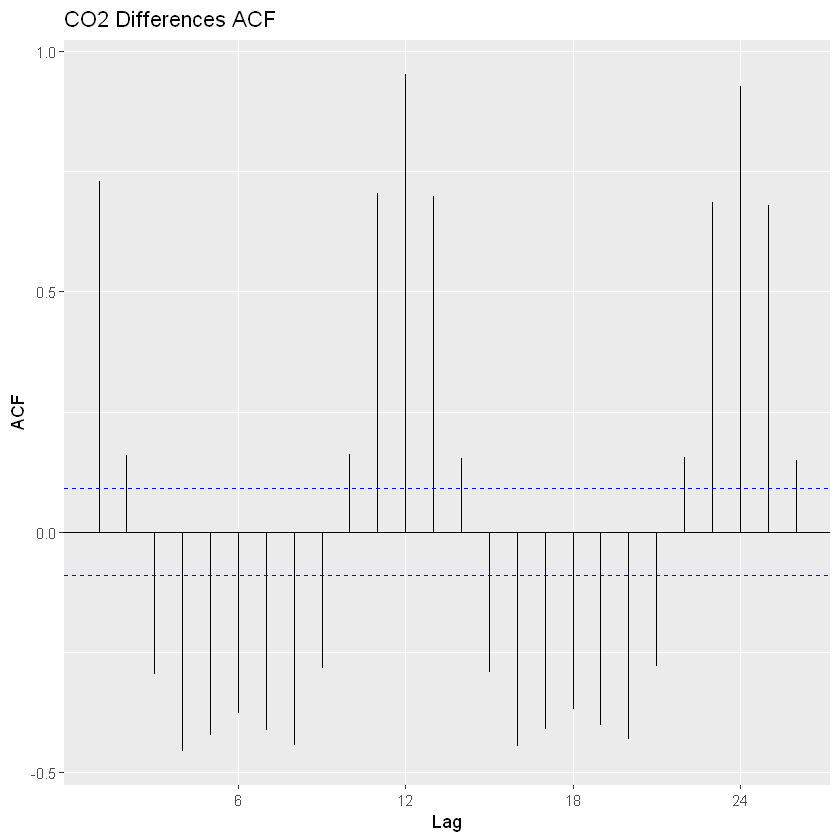

In [29]:
ggAcf(diffs)+ggtitle("CO2 Differences ACF")

In [ ]:
The seasonal component is obscuring the picture. We now apply seasonal differencing to the data,
and rerun the ACF and PACF.

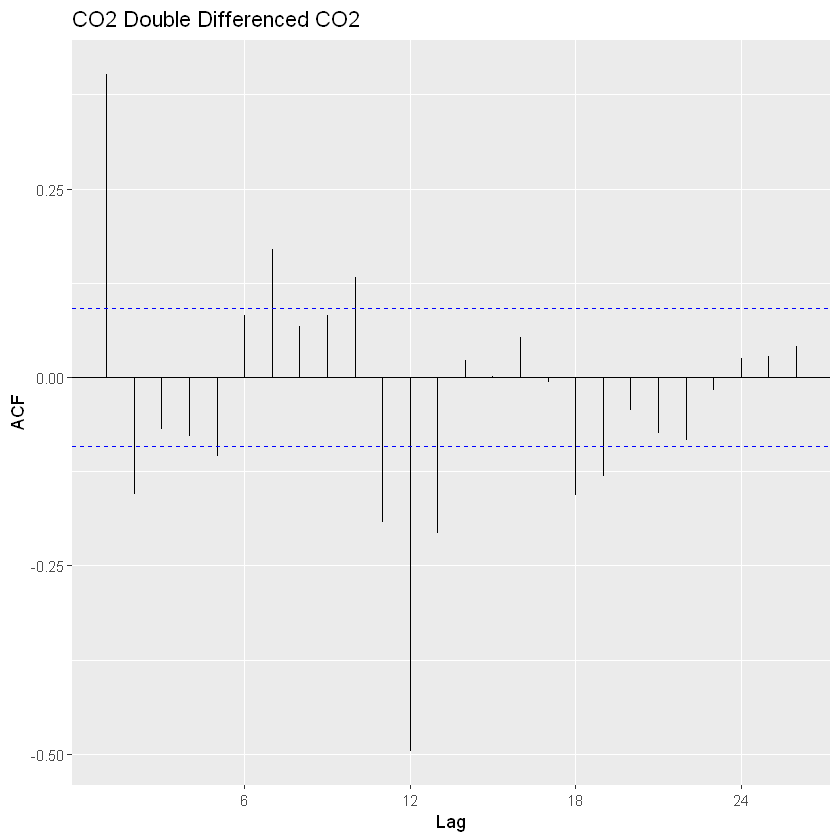

In [30]:
diffs2 = diff(diffs,lag = 12)
ggAcf(diffs2)+ggtitle("CO2 Double Differenced CO2")

For moving average processes, the ACF function typically has one or more spikes, and then decays 
sharply to zero, while the PACF function is very erratic. This is exactly what we have here,
indicating that we are dealing with a moving average process. 

When looking at the ACF plot, we can see one spike at lag 1 and another spike at lag 12, indicating that we have a moving average component of order 1, and a seasonal moving average component of order 1. 

Let's determine whether the auto.arima function in the forecast package confirms our analysis.

In [31]:
co2_arima = auto.arima(co2_global_ts,seasonal=TRUE,approximation=FALSE,ic='bic')
summary(co2_arima)

Series: co2_global_ts 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
         ma1     sma1
      0.8092  -0.8656
s.e.  0.0241   0.0275

sigma^2 estimated as 0.01676:  log likelihood=328.39
AIC=-650.78   AICc=-650.72   BIC=-638.39

Training set error measures:
                     ME      RMSE        MAE         MPE       MAPE       MASE
Training set 0.00500459 0.1273741 0.09200933 0.001226231 0.02519071 0.05083694
                   ACF1
Training set 0.04988207


The auto.arima function has suggested a moving average component of order 1 and a seasonal moving average component of order 1, as predicted. Thus, the best SARIMA model is one with a moving average component of order 1 and a seasonal moving average component of order 1, as well as differencing and seasonal differencing, each of order 1. Next, we assess the goodness of the fit.

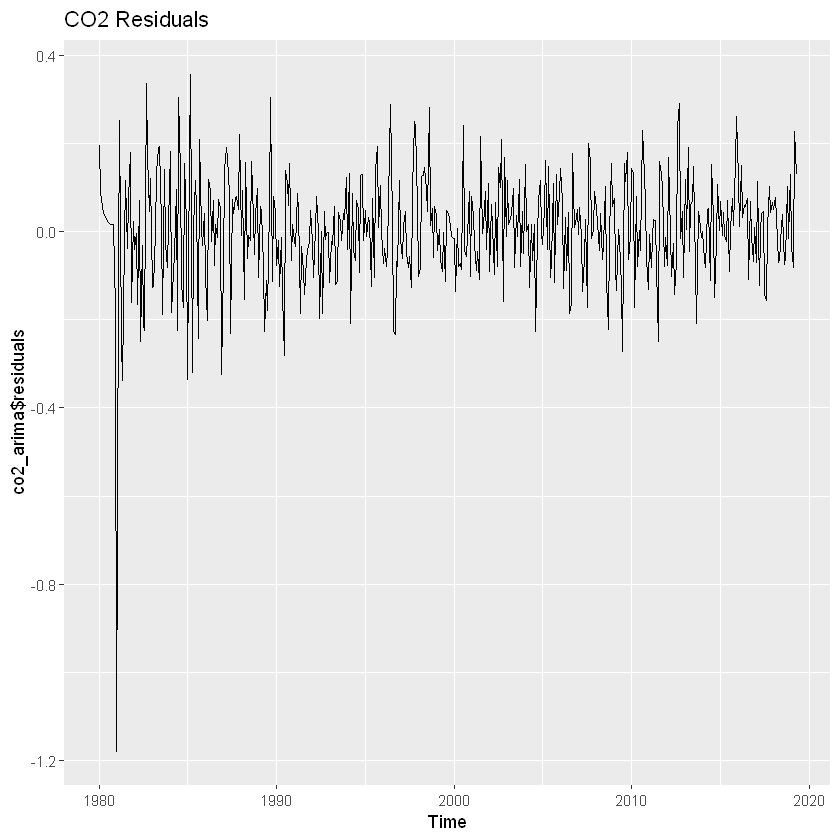

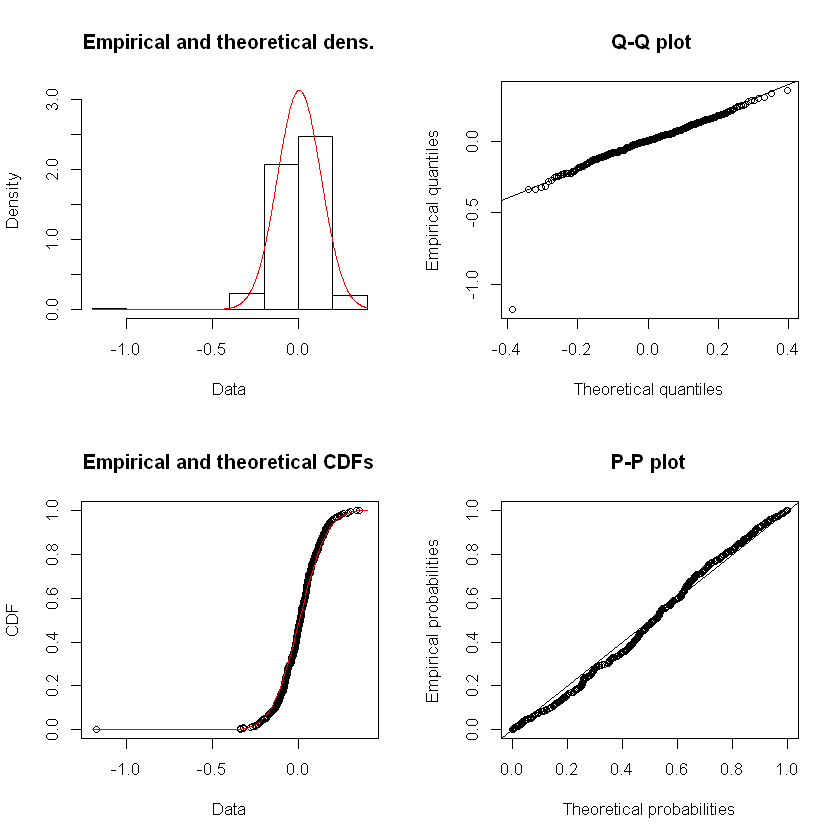

In [33]:
autoplot(co2_arima$residuals)+ggtitle("CO2 Residuals")
resid.fit = fitdist(as.numeric(co2_arima$residuals),distr="norm")
plot(resid.fit)

In both plots, we see that the residuals appear to be Gaussian white noise, with one significant outlier. If we ignore this one outlier, are the residuals Gaussian white noise?

In [35]:
outlier_position = which(abs(co2_arima$residuals)>=1)
residuals_minus_outlier = co2_arima$residuals[-(outlier_position)]

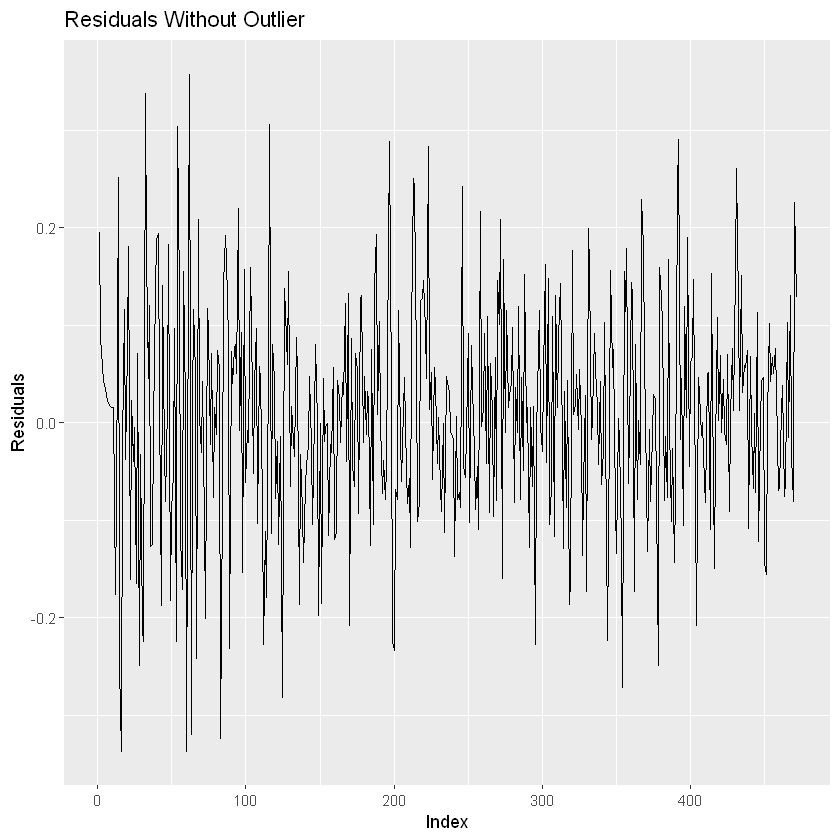


	Shapiro-Wilk normality test

data:  residuals_minus_outlier
W = 0.99588, p-value = 0.2573



	Anderson-Darling normality test

data:  residuals_minus_outlier
A = 0.58187, p-value = 0.1294


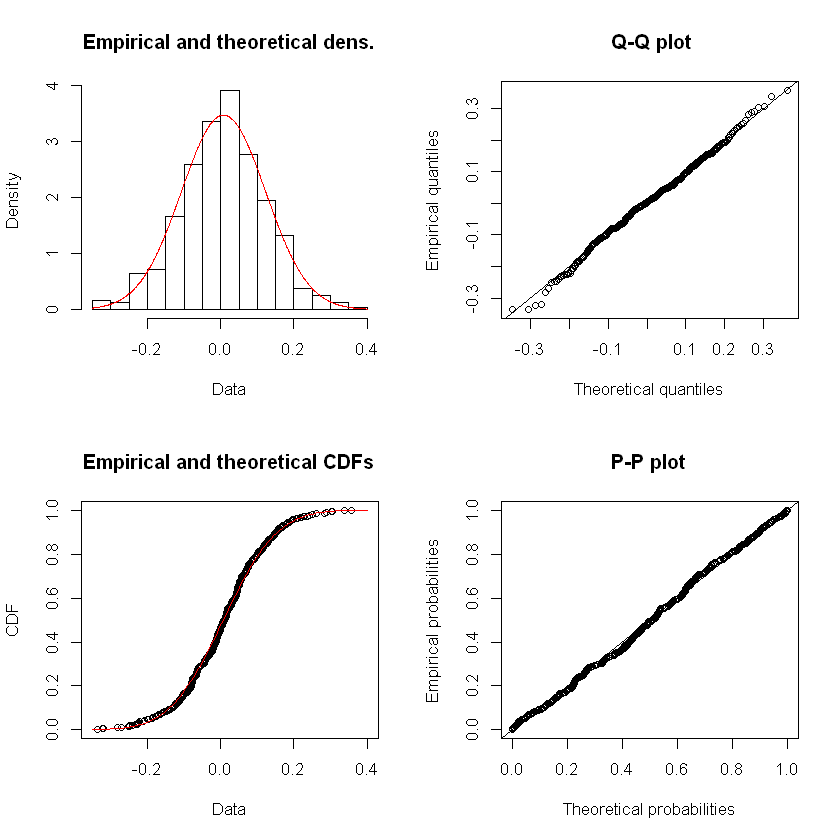

In [36]:
ggplot(data = data.frame(residuals_minus_outlier),aes(y=residuals_minus_outlier))+
  geom_line(aes(y=residuals_minus_outlier,x=1:length(residuals_minus_outlier)))+
  ggtitle("Residuals Without Outlier")+
  ylab("Residuals")+
  xlab("Index")
new_resid_fit = fitdist(residuals_minus_outlier,dist="norm")
plot(new_resid_fit)
shapiro.test(residuals_minus_outlier)
ad.test(residuals_minus_outlier)

All tests and visuals indicate that the residuals, apart from the single outlier, are Gaussian white noise, which suggests a very good fit.

We will now perform cross-validation on our model, by the following process. Take the first 350 data points, fit a model of the form (0,1,1)(0,1,1)[12] as above, and make predictions for the next 100 data points. Then assess the absolute error at each of these forecast horizons. Repeat this process, this time using the first 351 points. Then average the absolute forecast error at each forecast horizon.

In [37]:
far2 <- function(x, h){forecast(Arima(x,order=c(0,1,1),seasonal = c(0,1,1)),h=h)}
e <- tsCV(co2_global_ts,far2,h=100,initial = 350)
mae = colMeans(abs(e),na.rm=TRUE)

Next, we visualize the mean absolute errors.

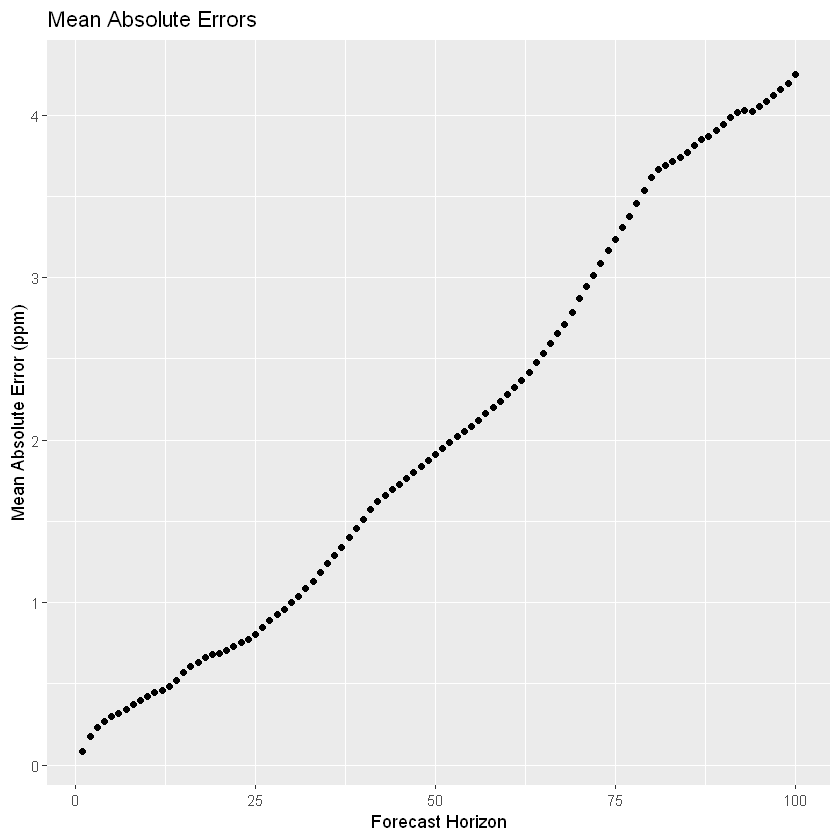

In [38]:
ggplot(as.data.frame(mae))+
  geom_point(aes(y=mae,x=c(1:100)))+
  labs(title = "Mean Absolute Errors",x='Forecast Horizon',y='Mean Absolute Error (ppm)')

The cross validation reveals that the mean absolute error of the ARIMA model is growing approximately linearly. The mean absolute error is less than 1 ppm for a forecast horizon of up to 30 months.

We now plot the 30-month forecast.

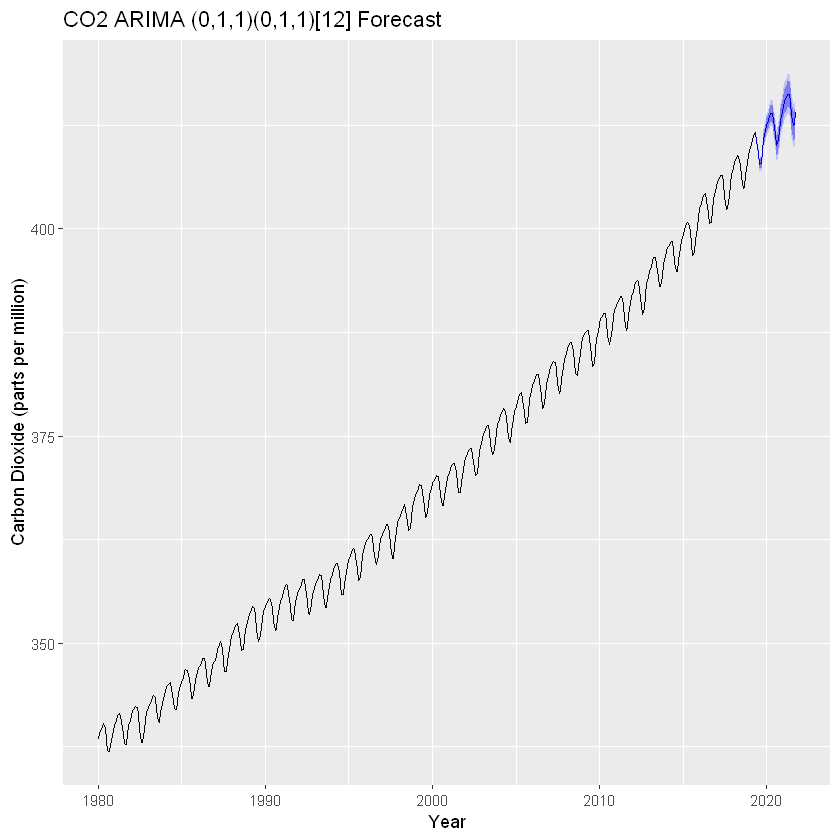

In [39]:
co2_forecast = forecast(co2_arima,h=30)
autoplot(co2_forecast)+ylab("Carbon Dioxide (parts per million)")+xlab("Year")+
  ggtitle("CO2 ARIMA (0,1,1)(0,1,1)[12] Forecast")

An extended forecast of 100 months is also available, but we must remember that the extended forecast is accompanied by increased forecast error. A 100-month forecast horizon has a mean absolute error of approximately 4 ppm.

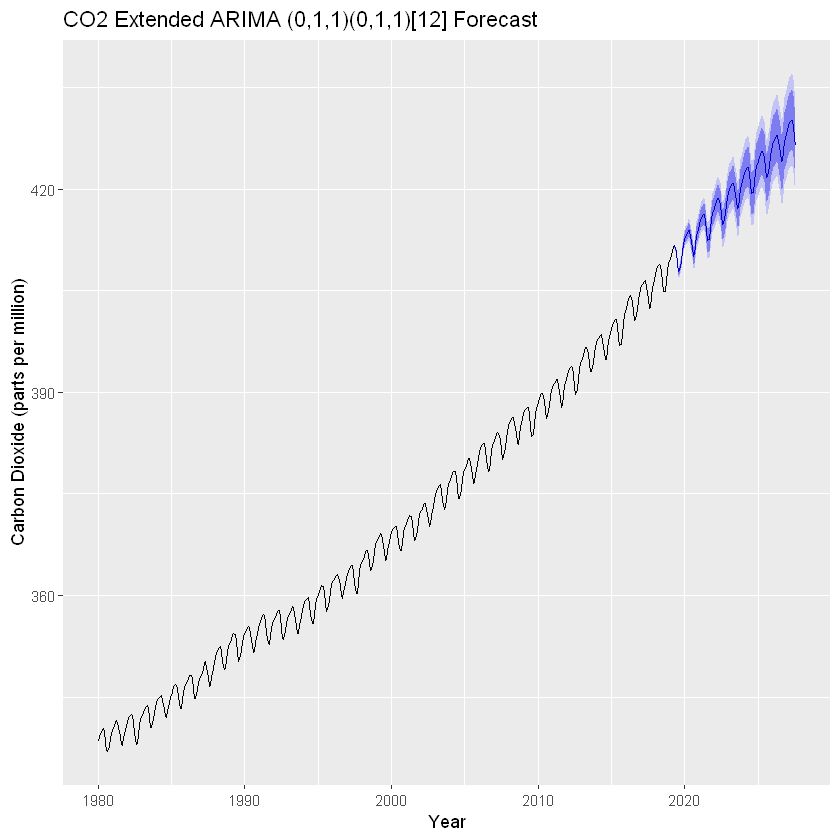

In [40]:
co2_extended_forecast = forecast(co2_arima,h=100)
autoplot(co2_extended_forecast)+ylab("Carbon Dioxide (parts per million)")+xlab("Year")+
  ggtitle("CO2 Extended ARIMA (0,1,1)(0,1,1)[12] Forecast")

According to this extended forecast, CO2 levels are predicted to top 420 ppm for each month of the year by 2025, with a mean forecast value of 424.10 for January 2025. Looking further ahead, the first mean predicted value of over 430 ppm occurs in April 2027. It should be noted that the mean absolute errors at these forecast horizons is calculated above to be approximately 2.79 ppm and 4.08 ppm respectively.

In conclusion, CO2 atmospheric levels can be accurately forecast using SARIMA methodologies and are predicted to continue to rise in the foreseeable future. This represents a significant challenge, which the global community must address. Please stay tuned for additional climatological analysis.

Thank you to Rob Hyndman et al. for designing the fantastic forecast package in R.